In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn.functional as F 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

In [2]:
data_path = 'C:/Users/Yuey/Downloads/archive/simpsons_dataset'
characters = {}
for idx, folder_name in enumerate(os.listdir(data_path)):
    folder_path = os.path.join(data_path, folder_name)
    if os.path.isdir(folder_path):
        characters[idx] = folder_name

print(characters)

{0: 'abraham_grampa_simpson', 1: 'agnes_skinner', 2: 'apu_nahasapeemapetilon', 3: 'barney_gumble', 4: 'bart_simpson', 5: 'carl_carlson', 6: 'charles_montgomery_burns', 7: 'chief_wiggum', 8: 'cletus_spuckler', 9: 'comic_book_guy', 10: 'disco_stu', 11: 'edna_krabappel', 12: 'fat_tony', 13: 'gil', 14: 'groundskeeper_willie', 15: 'homer_simpson', 16: 'kent_brockman', 17: 'krusty_the_clown', 18: 'lenny_leonard', 19: 'lionel_hutz', 20: 'lisa_simpson', 21: 'maggie_simpson', 22: 'marge_simpson', 23: 'martin_prince', 24: 'mayor_quimby', 25: 'milhouse_van_houten', 26: 'miss_hoover', 27: 'moe_szyslak', 28: 'ned_flanders', 29: 'nelson_muntz', 30: 'otto_mann', 31: 'patty_bouvier', 32: 'principal_skinner', 33: 'professor_john_frink', 34: 'rainier_wolfcastle', 35: 'ralph_wiggum', 36: 'selma_bouvier', 37: 'sideshow_bob', 38: 'sideshow_mel', 39: 'snake_jailbird', 40: 'troy_mcclure', 41: 'waylon_smithers'}


In [3]:
class CharacterDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        data = []
        class_images = {label: [] for label in characters.keys()}

        for label, character in characters.items():
            character_dir = os.path.join(self.image_dir, character)
            if os.path.exists(character_dir):
                images = os.listdir(character_dir)
                for img in images:
                    img_path = os.path.join(character_dir, img)
                    class_images[label].append(img_path)

        max_class_size = 300

        for label, images in class_images.items():
            while len(images) < max_class_size:
                images += random.sample(images, min(max_class_size - len(images), len(images)))
            images = images[:max_class_size]
            data.extend((label, img_path) for img_path in images) 

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if isinstance(idx, int):
            label, img_path = self.data[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        else:
            raise TypeError("Index must be an integer")
        
    def count_images_per_class(self):
        counts = {}
        for label, img_path in self.data:
            counts[label] = counts.get(label, 0) + 1
        return counts

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [4]:
full_dataset = CharacterDataset(data_path, transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.6313726].


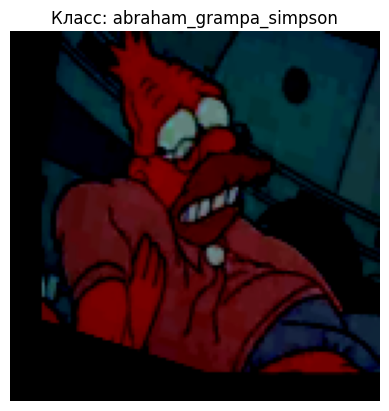

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.7647059].


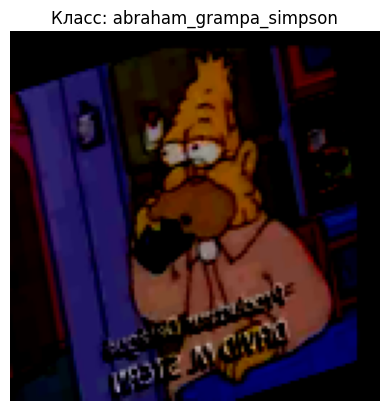

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.9137255].


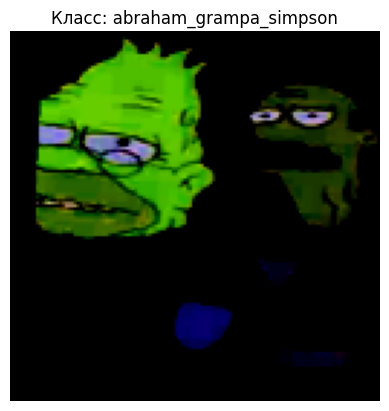

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.5764706].


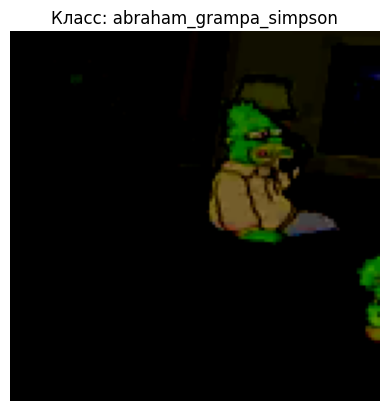

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.49803925].


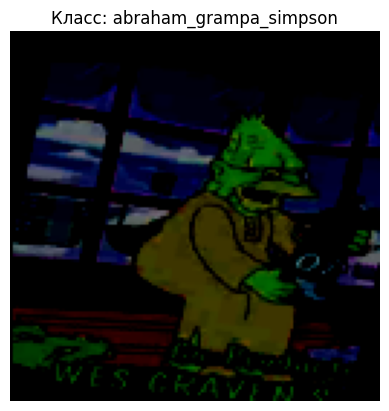

In [5]:
for i in range(5):
    image, label = full_dataset[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f'Класс: {characters[label]}')
    plt.axis('off')
    plt.show()

In [6]:
image_counts = full_dataset.count_images_per_class()

for label, count in image_counts.items():
    print(f'Класс {characters[label]}: {count} изображений')
    
labels = [label for label, _ in full_dataset.data]

train_data, temp_data = train_test_split(full_dataset.data, test_size=0.3, stratify=labels, random_state=42)

val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=[label for label, _ in temp_data], random_state=42)

train_indices = [full_dataset.data.index(item) for item in train_data]
val_indices = [full_dataset.data.index(item) for item in val_data]
test_indices = [full_dataset.data.index(item) for item in test_data]

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

print(f'Количество изображений в обучающем наборе: {len(train_dataset)}')
print(f'Количество изображений в валидационном наборе: {len(val_dataset)}')
print(f'Количество изображений в тестовом наборе: {len(test_dataset)}')



Класс abraham_grampa_simpson: 300 изображений
Класс agnes_skinner: 300 изображений
Класс apu_nahasapeemapetilon: 300 изображений
Класс barney_gumble: 300 изображений
Класс bart_simpson: 300 изображений
Класс carl_carlson: 300 изображений
Класс charles_montgomery_burns: 300 изображений
Класс chief_wiggum: 300 изображений
Класс cletus_spuckler: 300 изображений
Класс comic_book_guy: 300 изображений
Класс disco_stu: 300 изображений
Класс edna_krabappel: 300 изображений
Класс fat_tony: 300 изображений
Класс gil: 300 изображений
Класс groundskeeper_willie: 300 изображений
Класс homer_simpson: 300 изображений
Класс kent_brockman: 300 изображений
Класс krusty_the_clown: 300 изображений
Класс lenny_leonard: 300 изображений
Класс lionel_hutz: 300 изображений
Класс lisa_simpson: 300 изображений
Класс maggie_simpson: 300 изображений
Класс marge_simpson: 300 изображений
Класс martin_prince: 300 изображений
Класс mayor_quimby: 300 изображений
Класс milhouse_van_houten: 300 изображений
Класс miss_hoo

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=True)
model.fc = nn.Linear(model.fc.in_features, len(characters))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
train_losses = []
val_losses = []
val_accuracies = []
precisions = []
recalls = []

for epoch in range(num_epochs):
    print(f"epoch: {epoch+1}")
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, ')

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    precision_per_class = precision_score(val_labels, val_predictions, average=None, zero_division=0)
    recall_per_class = recall_score(val_labels, val_predictions, average=None)

    precisions.append(np.mean(precision_per_class))
    recalls.append(np.mean(recall_per_class))

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Accuracy: {val_accuracies[-1]:.2f}%, '
          f'Precision: {precisions[-1]:.4f}, '
          f'Recall: {recalls[-1]:.4f}, ')

    for i, (p, r) in enumerate(zip(precision_per_class, recall_per_class)):
        print(f'Class {i}: Precision: {p:.4f}, Recall: {r:.4f}')


c:\Users\Yuey\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 1
Epoch [1/15], Train Loss: 1.6261, 
Epoch [1/15], Train Loss: 1.6261, Val Loss: 1.4531, Val Accuracy: 61.80%, Precision: 0.7304, Recall: 0.6180, 
Class 0: Precision: 0.6415, Recall: 0.7556
Class 1: Precision: 1.0000, Recall: 0.3778
Class 2: Precision: 0.7000, Recall: 0.3111
Class 3: Precision: 0.7667, Recall: 0.5111
Class 4: Precision: 1.0000, Recall: 0.0444
Class 5: Precision: 0.8158, Recall: 0.6889
Class 6: Precision: 0.4524, Recall: 0.4222
Class 7: Precision: 0.5316, Recall: 0.9333
Class 8: Precision: 0.6364, Recall: 0.6222
Class 9: Precision: 1.0000, Recall: 0.1778
Class 10: Precision: 0.9149, Recall: 0.9556
Class 11: Precision: 1.0000, Recall: 0.4000
Class 12: Precision: 0.9512, Recall: 0.8667
Class 13: Precision: 0.7447, Recall: 0.7778
Class 14: Precision: 0.7308, Recall: 0.4222
Class 15: Precision: 0.3929, Recall: 0.7333
Class 16: Precision: 0.9118, Recall: 0.6889
Class 17: Precision: 0.5147, Recall: 0.7778
Class 18: Precision: 0.2603, Recall: 0.8444
Class 19: Precision:

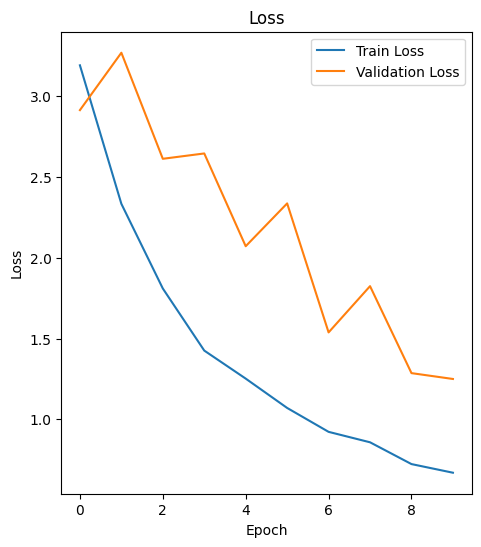

In [9]:

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


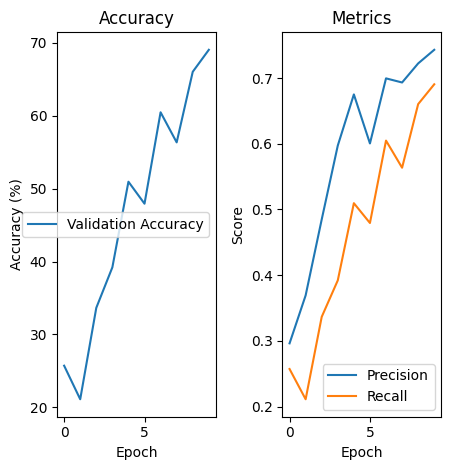

In [16]:

plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(precisions, label='Precision')
plt.plot(recalls, label='Recall')
plt.title('Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:

model.eval()
test_labels = []
test_predictions = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())

print(f'Тестовая точность: {100 * correct / total:.2f}%')

precision_per_class = precision_score(val_labels, val_predictions, average=None, zero_division=0)
recall_per_class = recall_score(val_labels, val_predictions, average=None)

precisions.append(np.mean(precision_per_class))
recalls.append(np.mean(recall_per_class))

print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, '
          f'Val Accuracy: {val_accuracies[-1]:.2f}%, '
          f'Precision: {precisions[-1]:.4f}, '
          f'Recall: {recalls[-1]:.4f}, ')

for i, (p, r, f1) in enumerate(zip(precision_per_class, recall_per_class)):
    print(f'Class {i}: Test Precision: {p:.4f}, Test Recall: {r:.4f}')

Тестовая точность: 74.44%
Тестовая Precision: 0.7958
Тестовая Recall: 0.7444
